In [1]:
import tslearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn import metrics
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.piecewise import PiecewiseAggregateApproximation
import warnings
warnings.filterwarnings('ignore')

I used Weights&Biases on this notebook to monitor and track the performance of k-means 

In [2]:
import wandb
wandb.init(project="tscluster", entity="pillarxyz")

config = wandb.config
config.seed = 42
config.metric = 'dtw'
config.n_clusters = 4
config.run_dimrec = True
np.random.seed(config.seed)
wandb.config.update(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pillarxyz (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-02-04 13:52:49.436820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-04 13:52:49.436856: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
%env "WANDB_NOTEBOOK_NAME" "tscluster"

env: "WANDB_NOTEBOOK_NAME"="tscluster"


# Reading Data

In [4]:
stocks_df = pd.read_csv("data/stocks.csv")

the dataset consists of closing prices of over 70 moroccan stocks including the MASI index

In [5]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,Aradei Capital,ATLANTASANAD,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,25/01/2017,51.00,NaN,NaN,NaN,2499.0,124.90,1291.0,NaN,48.99,...,277.00,2350.0,57.10,804.8,NaN,1569.0,NaN,NaN,137.05,12521.4071
1,26/01/2017,50.50,840.0,NaN,NaN,2465.0,119.15,1291.0,NaN,48.00,...,277.00,2300.0,54.03,805.0,275.00,1530.0,NaN,4900.0,137.05,12430.7352
2,27/01/2017,50.56,840.0,NaN,2650.0,2465.0,124.00,1299.0,NaN,48.60,...,277.00,2300.0,55.36,810.0,275.00,1530.0,NaN,4945.0,140.00,12507.9939
3,30/01/2017,49.00,840.0,300.0,2650.0,2465.0,121.00,1299.0,NaN,48.11,...,277.00,2300.0,54.30,799.2,258.55,1500.0,NaN,4940.0,140.00,12385.2062
4,31/01/2017,48.00,832.0,300.0,2625.0,2465.0,122.80,1299.0,NaN,48.74,...,277.00,2300.0,54.00,800.5,243.05,1510.0,NaN,4940.0,140.00,12228.8961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,24/01/2022,11.56,1397.0,350.0,5700.0,5012.0,40.21,1404.0,450.10,132.50,...,155.00,3000.0,55.51,1220.0,144.90,1780.0,143.0,4760.0,81.00,13753.5026
1241,25/01/2022,11.49,1397.0,349.0,5700.0,4850.0,38.85,1404.0,450.50,132.50,...,150.05,3000.0,56.50,1200.0,141.00,1775.0,143.0,4766.0,84.00,13706.6203
1242,26/01/2022,11.50,1397.0,348.5,5800.0,4850.0,39.74,1415.0,450.50,132.50,...,150.05,3000.0,56.00,1215.0,141.00,1775.0,143.0,4800.0,86.00,13722.2847
1243,27/01/2022,11.62,1397.0,349.9,5620.0,4850.0,39.00,1451.0,450.65,132.50,...,152.00,3000.0,57.80,1200.0,141.00,1810.0,143.0,4800.0,89.43,13733.8642


### Formatting the date column

In [6]:
stocks_df.date = pd.to_datetime(stocks_df.date, format='%d/%m/%Y')

## Cleaning Data

In [7]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

SAMIR             100.000000
Diac Salaf        100.000000
Aradei Capital     77.349398
Mutandis           37.831325
Immr Invest        26.265060
Nexans Maroc        3.293173
Unimer              2.088353
Central.Danone      1.847390
BALIMA              1.686747
Rebab Company       1.606426
Agma                1.606426
Dari Couspate       1.204819
Maroc Leasing       1.044177
Afric Indus         1.044177
Auto Nejma          0.883534
dtype: float64

we remove columns having no data and then we fill the missing values with past or future values

In [8]:
stocks_df.drop(columns = ["SAMIR", "Diac Salaf", "Aradei Capital", "Mutandis", "Immr Invest"], inplace = True)

In [9]:
stocks_df = stocks_df.ffill()
stocks_df = stocks_df.bfill()

In [10]:
(stocks_df.isnull().sum()*100 / stocks_df.shape[0]).sort_values(ascending = False).head(15)

date               0.0
Med Paper          0.0
Res.Dar Saada      0.0
Rebab Company      0.0
PROMOPHARM         0.0
Oulmes             0.0
Nexans Maroc       0.0
Microdata          0.0
Maroc Telecom      0.0
S2M                0.0
Maroc Leasing      0.0
Managem            0.0
Maghrebail         0.0
Maghreb Oxygene    0.0
M2M Group          0.0
dtype: float64

In [11]:
stocks_df

,date,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
0,2017-01-25,51.00,840.0,300.0,2650.0,2499.0,124.90,1291.0,48.99,435.00,...,277.00,2350.0,57.10,804.8,275.00,1569.0,180.0,4900.0,137.05,12521.4071
1,2017-01-26,50.50,840.0,300.0,2650.0,2465.0,119.15,1291.0,48.00,428.10,...,277.00,2300.0,54.03,805.0,275.00,1530.0,180.0,4900.0,137.05,12430.7352
2,2017-01-27,50.56,840.0,300.0,2650.0,2465.0,124.00,1299.0,48.60,429.40,...,277.00,2300.0,55.36,810.0,275.00,1530.0,180.0,4945.0,140.00,12507.9939
3,2017-01-30,49.00,840.0,300.0,2650.0,2465.0,121.00,1299.0,48.11,427.00,...,277.00,2300.0,54.30,799.2,258.55,1500.0,180.0,4940.0,140.00,12385.2062
4,2017-01-31,48.00,832.0,300.0,2625.0,2465.0,122.80,1299.0,48.74,420.00,...,277.00,2300.0,54.00,800.5,243.05,1510.0,180.0,4940.0,140.00,12228.8961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,2022-01-24,11.56,1397.0,350.0,5700.0,5012.0,40.21,1404.0,132.50,492.00,...,155.00,3000.0,55.51,1220.0,144.90,1780.0,143.0,4760.0,81.00,13753.5026
1241,2022-01-25,11.49,1397.0,349.0,5700.0,4850.0,38.85,1404.0,132.50,492.20,...,150.05,3000.0,56.50,1200.0,141.00,1775.0,143.0,4766.0,84.00,13706.6203
1242,2022-01-26,11.50,1397.0,348.5,5800.0,4850.0,39.74,1415.0,132.50,491.75,...,150.05,3000.0,56.00,1215.0,141.00,1775.0,143.0,4800.0,86.00,13722.2847
1243,2022-01-27,11.62,1397.0,349.9,5620.0,4850.0,39.00,1451.0,132.50,494.50,...,152.00,3000.0,57.80,1200.0,141.00,1810.0,143.0,4800.0,89.43,13733.8642


we resample our time series from daily to weekly data

In [12]:
stocks_df = stocks_df.resample('7D', on = 'date').first().reset_index(drop = True)

In [13]:
stocks_df.index = stocks_df.date

In [14]:
stocks_df.drop("date", axis = 1, inplace = True)

In [15]:
stocks_df

,Addoha,AFMA,Afric Indus,Afriquia Gaz,Agma,Alliances,Aluminium Maroc,ATLANTASANAD,Attijariwafa,Auto Hall,...,SRM,Ste Boissons,STROC Indus,TAQA Morocco,Timar,Total Maroc,Unimer,Wafa Assur,Zellidja,MASI
date,,,,,,,,,,,,,,,,,,,,,
2017-01-25,51.00,840.0,300.0,2650.0,2499.0,124.90,1291.0,48.99,435.00,114.00,...,277.00,2350.0,57.10,804.8,275.00,1569.0,180.0,4900.0,137.05,12521.4071
2017-02-01,46.06,832.0,300.0,2625.0,2465.0,115.00,1300.0,47.15,411.20,114.90,...,283.45,2300.0,53.10,800.0,243.00,1500.0,180.0,4850.0,140.00,12163.6391
2017-02-08,49.95,850.0,300.0,2600.0,2342.0,133.20,1230.0,49.28,430.05,115.50,...,290.00,2300.0,52.70,809.0,227.65,1522.0,180.0,4927.0,140.00,12297.3179
2017-02-15,51.15,864.8,296.2,2755.0,2475.0,165.15,1230.0,48.50,430.00,114.80,...,336.75,2350.0,50.00,796.0,225.75,1502.0,180.0,4950.0,149.45,12279.5277
2017-02-22,49.70,900.0,296.0,2700.0,2489.0,179.00,1230.0,53.00,414.00,110.00,...,364.00,2350.0,49.05,790.0,211.00,1460.0,170.0,4740.0,149.00,11954.0850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-29,10.85,1370.0,343.0,5500.0,4490.0,38.80,1400.0,114.65,485.00,105.00,...,146.00,2820.0,38.50,1110.0,137.90,1785.0,142.0,4848.0,76.81,13389.2014
2022-01-05,10.70,1360.0,343.0,5205.0,4730.0,38.10,1392.0,119.30,482.10,105.50,...,146.00,2859.0,41.48,1100.0,137.90,1731.0,141.4,4756.0,74.00,13290.6250
2022-01-12,11.40,1350.0,345.0,5404.0,4550.0,39.00,1428.0,136.50,491.00,112.00,...,147.00,2859.0,43.20,1104.0,141.00,1750.0,142.0,4707.0,76.95,13531.2560


In [16]:
stocks = stocks_df

# Visualization

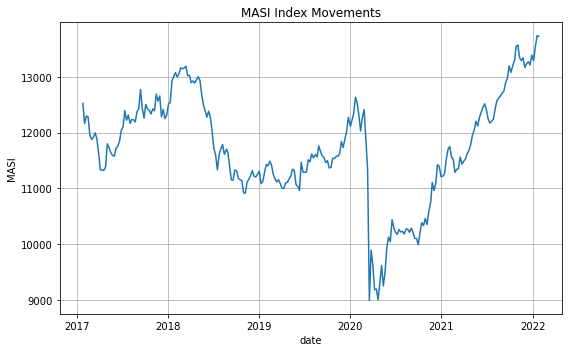

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(stocks_df.index, stocks_df["MASI"])
ax.grid()
ax.set_title('MASI Index Movements')
ax.set_ylabel('MASI')
ax.set_xlabel('date')
fig.tight_layout();

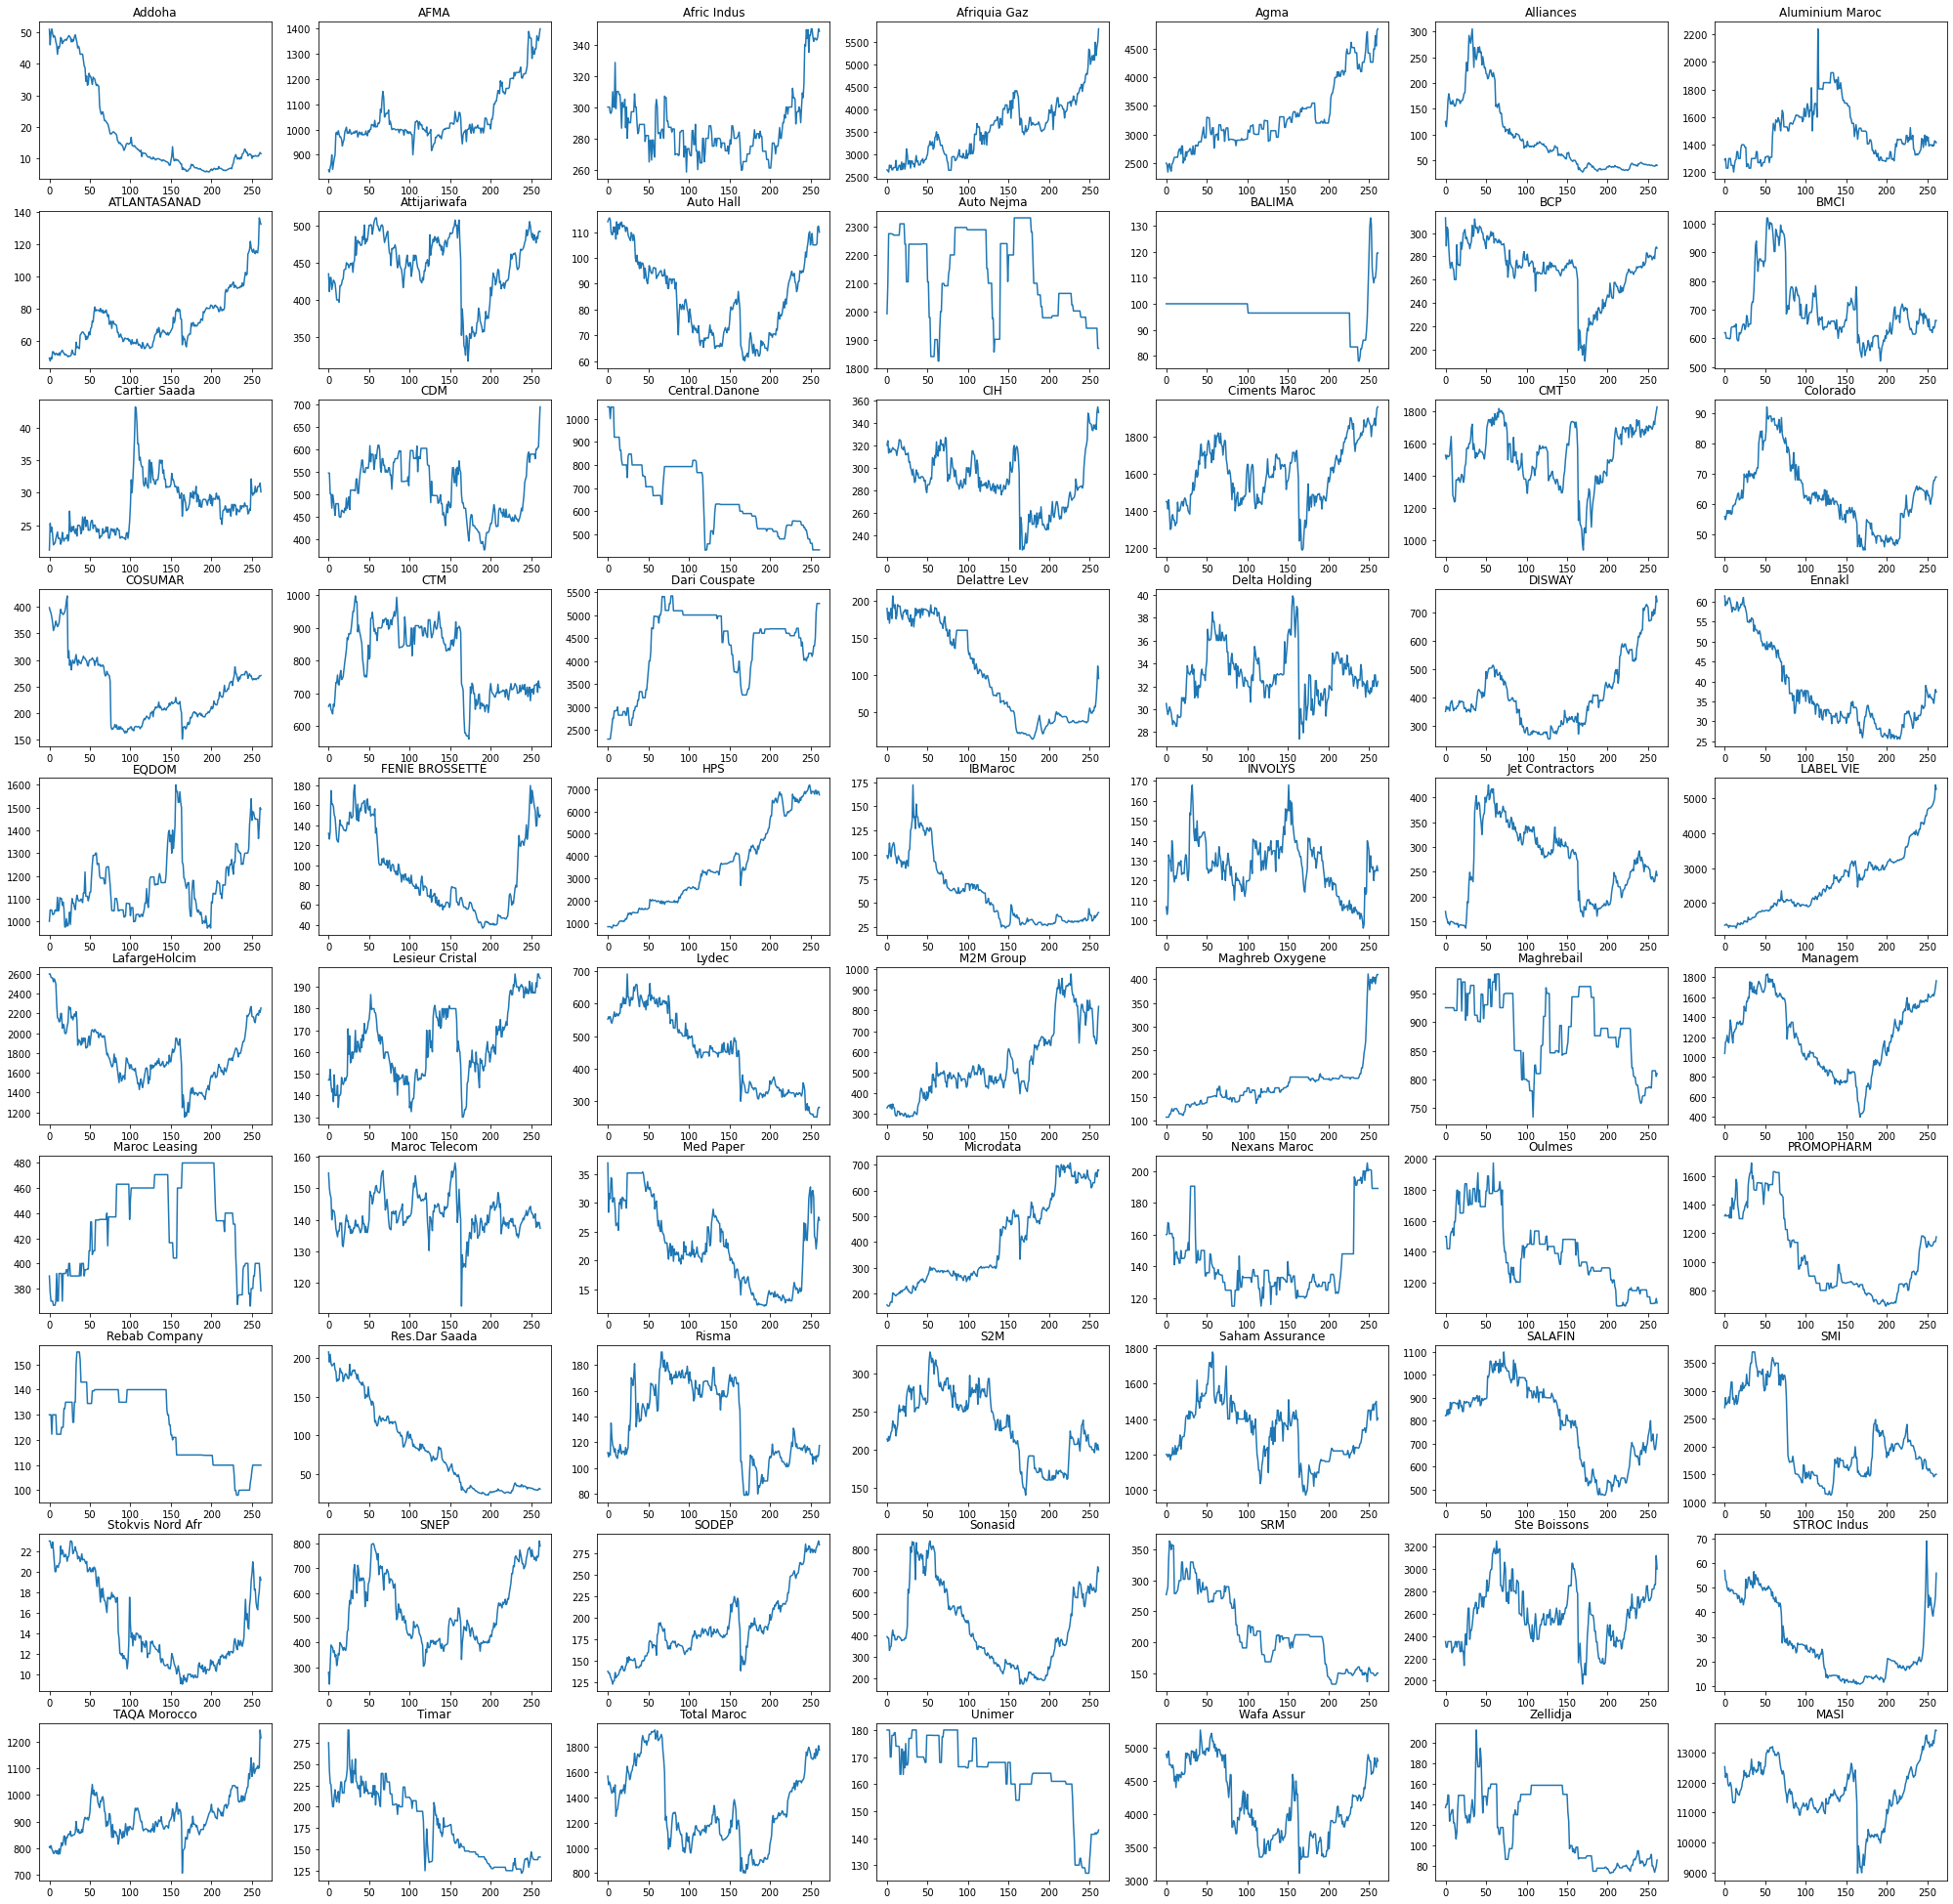

In [18]:
cols = stocks_df.columns

fig, axs = plt.subplots(10,7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        axs[i, j].plot(stocks_df[cols[i*7+j]].values)
        axs[i, j].set_title(cols[i*7+j])
plt.show()

# Dimensionality Reduction

we can use PAA (Piecewise Aggregate Approximation) for dimensionality reduction

In [19]:
ts = np.array(stocks.T).reshape(stocks.T.shape[0], stocks.T.shape[1], 1)
ts = TimeSeriesScalerMinMax().fit_transform(ts)

In [20]:
if config.run_dimrec:
    n_segments = 10
    paa = PiecewiseAggregateApproximation(n_segments = n_segments)
    ts = paa.fit_transform(ts)
    wandb.log({"paa_segments" : n_segments})
    
cols = stocks.columns

# Clustering

In [21]:
km = TimeSeriesKMeans(n_clusters = config.n_clusters, random_state = config.seed, metric = config.metric)
y_pred = km.fit_predict(ts)
s = silhouette_score(ts, y_pred, metric=config.metric)
print("K-means metrics : ")
print(f"Silhouette score = {s}, \nInertia = {km.inertia_}")

K-means metrics : 
Silhouette score = 0.3248057675086619, 
Inertia = 0.11255894528503084


In [22]:
wandb.run.summary["n_clusters"] = km.n_clusters
wandb.run.summary["silhouette_score"] = s
wandb.run.summary["Inertia"] = km.inertia_

In [23]:
wandb.log({"n_clusters" : km.n_clusters})
wandb.log({"silhouette_score" : s})
wandb.log({"Inertia" : km.inertia_})

In [24]:
wandb.config.update({'labels' : km.cluster_centers_})

In [25]:
clusters_df = pd.DataFrame({'Company':stocks.columns, 'Cluster': y_pred}).sort_values(by = 'Cluster')
clusters_df.reset_index(drop = True)

,Company,Cluster
0,Colorado,0
1,Jet Contractors,0
2,INVOLYS,0
3,Risma,0
4,Delta Holding,0
...,...,...
65,FENIE BROSSETTE,3
66,LafargeHolcim,3
67,Nexans Maroc,3
68,Sonasid,3


In [26]:
clusters_df.set_index('Company').to_csv("data/clustering-data.csv")

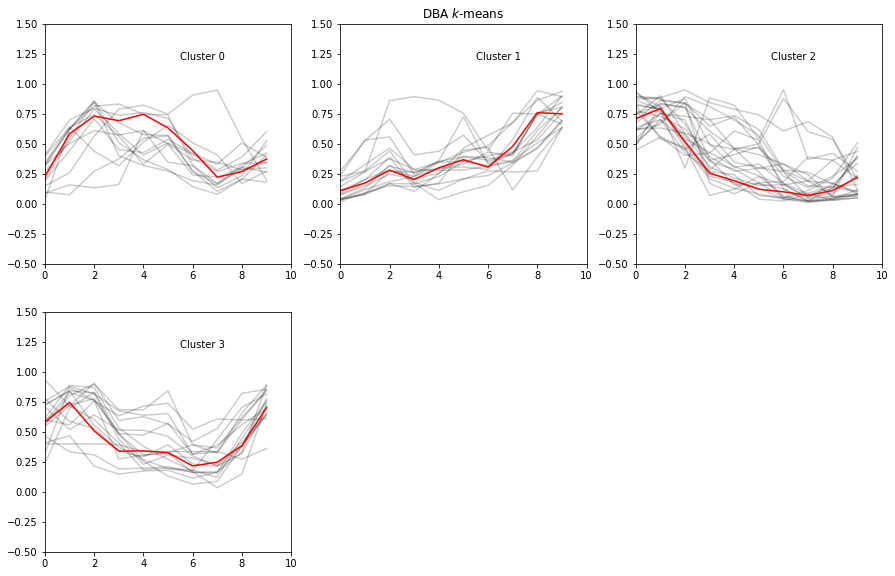

In [27]:
for yi in range(config.n_clusters):
    plt.subplot(3, 3, 4 + yi)
    for xx in ts[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, ts.shape[1])
    plt.ylim(-.5, 1.5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi),
             transform=plt.gca().transAxes)
    plt.gcf().set_size_inches(15, 15)
    if yi == 1:
        plt.title("DBA $k$-means")

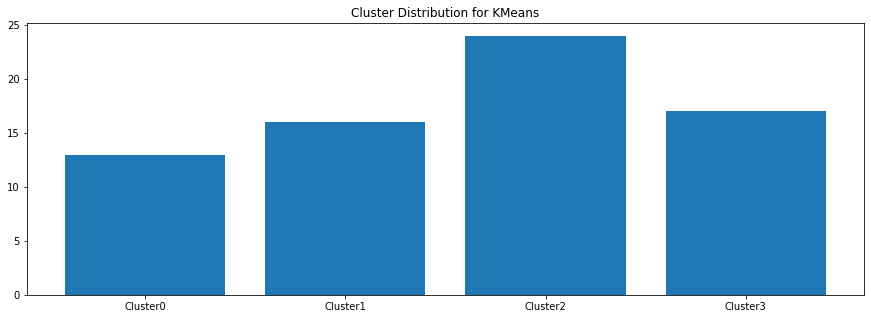

In [28]:
cluster_c = clusters_df["Cluster"].value_counts().sort_index()
cluster_n = [f"Cluster{str(i)}" for i in range(km.n_clusters)]
fig, ax = plt.subplots(1, 1,figsize=(15,5))
ax.set_title("Cluster Distribution for KMeans")
ax.bar(cluster_n, cluster_c)
plt.show()
wandb.log({"time series clustered": fig})

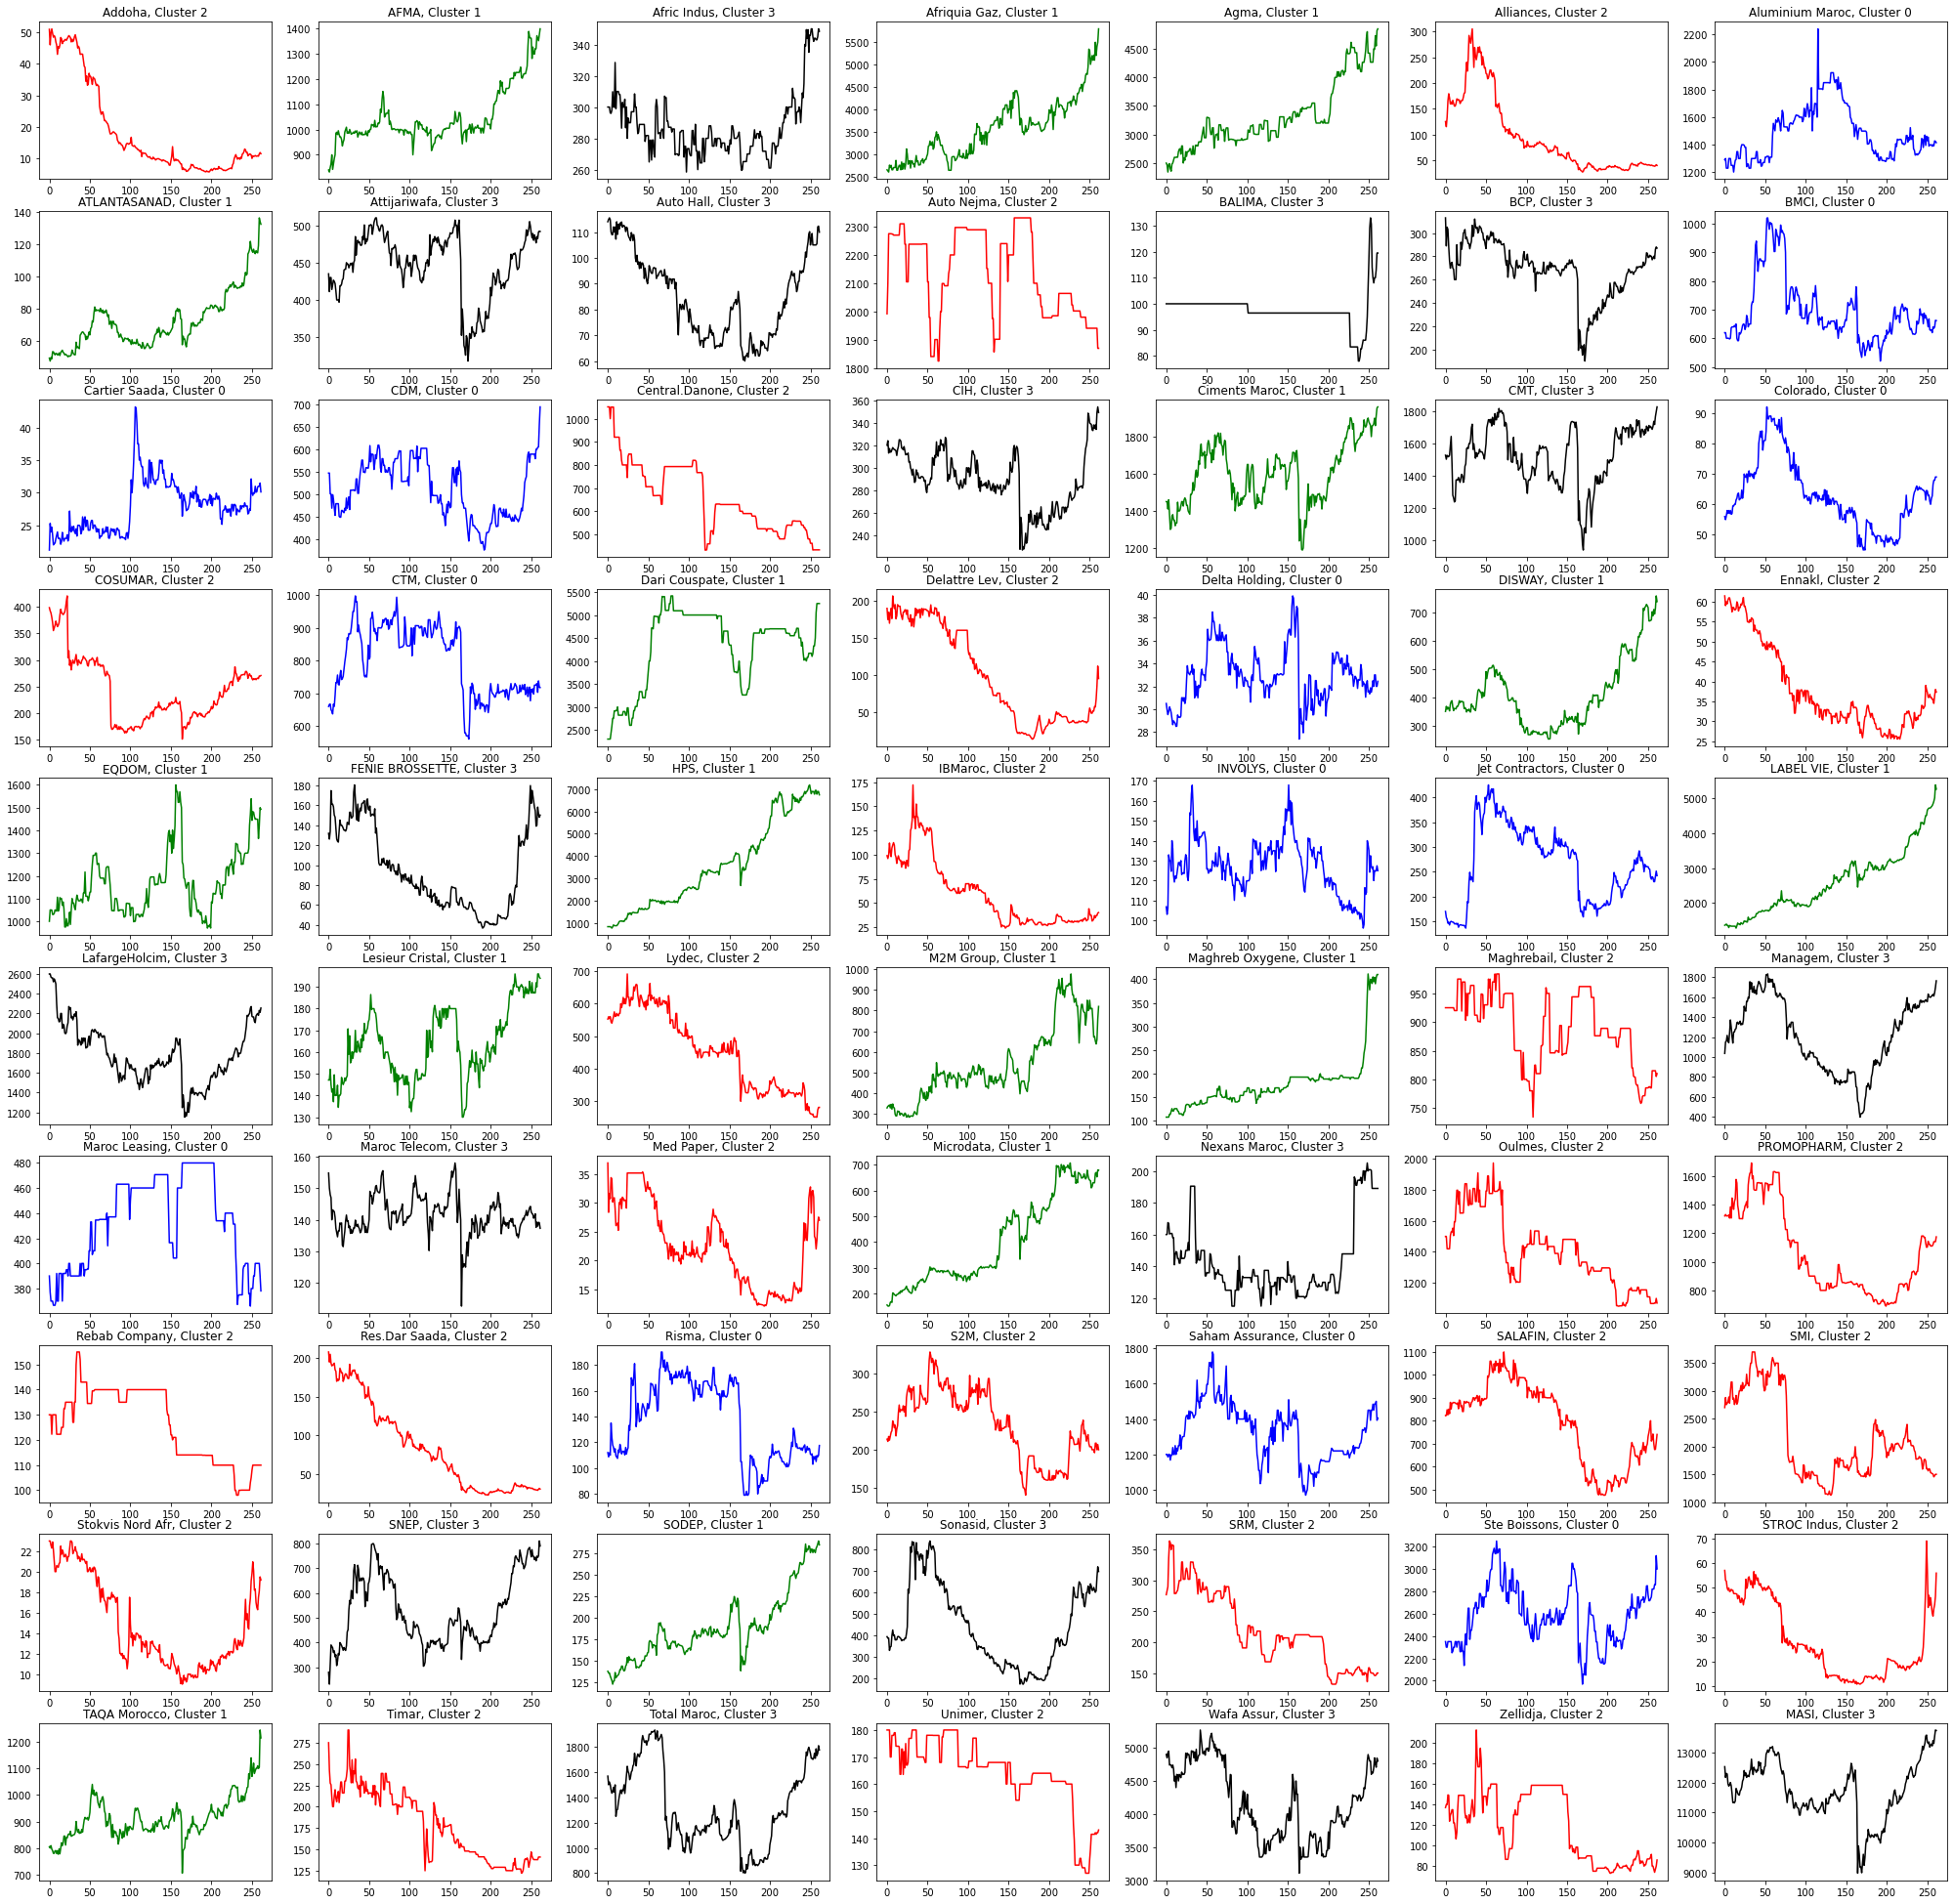

In [29]:
colors = ['blue', 'green','red', 'black', 'orange', 'brown', 'y']

fig, ax = plt.subplots(10, 7,figsize=(35,35))
for i in range(10):
    for j in range(7):
        try:
            ax[i, j].plot(stocks[cols[i*7+j]].values, color = colors[y_pred[i*7+j]])
            ax[i, j].set_title(f"{cols[i*7+j]}, Cluster {y_pred[i*7+j]}")
        except:
            fig.delaxes(ax[i, j])
            continue

plt.show()

# Conclusion

as we can see from the chart our algorithm did pretty well seperating stocks according to these patterns:
* Trending downward
* Trending upward
* Recovering from the pandemic
* Peaked during the pandemic

In [30]:
wandb.finish()

Inertia,▁
n_clusters,▁
paa_segments,▁
silhouette_score,▁
Inertia,0.11256
n_clusters,4
paa_segments,10
silhouette_score,0.32481
